# Bericht Projektlabor Maschinelles Lernen (PML)

|Gruppenmitglied|Matrikelnummer|
|---|---|
|Christian Singer|2161064|
|Domenic Gosein|2160647|
|Lukas Burger|2150580|
|Maximilian Kürschner|2160331|

Dozent: Dr.-Ing. Wei Yap Tan  

Fakultät der Informationstechnik  

Hochschule Mannheim  
Wintersemester 2021/22  

## Inhalt

1. Einleitung
2. Kalman Filter für den 1D Radarsensor
3. Experiment für den 1D Radarsensor
4. DBSCAN für den 3D Radarsensor
5. Kalman Filter für den 3D Radarsensor
6. Experiment für den 3D Radarsensor
7. Schlussfolgerung
8. Ausblick
9. Verwendete Literatur
10. Anhang

## Einleitung

Nach einer Einführung in maschinelles Lernen, war es unsere Aufgabe das Kalman Filter und den DBSCAN Algorithmus für Daten aus einem 1D und anschließend 3D Radarsensor zu implementieren.  

In [1]:
# Import aller benötigten Module
# Eigene Module
from DataGenerationRadar3D import *
from DBScan import *
#from Widgets3D import *
# Externe Module
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import copy
from collections import deque
from ipywidgets import interact, interactive, interactive_output, fixed, interact_manual
import ipywidgets as widgets
%matplotlib widget

Um ein besseres Verständis für das Kalman Filter zu erlangen, haben wir uns zunächst mit der Theorie dahinter beschäftigt. Im Zuge dieses Prozesses sind wir auf den --Filter gestoßen. Der -

-Filter bildet die Grundlage für eine Reihe von Filtern, darunter auch das Kalman Filter. Wir haben uns daher dazu entschlossen, diesen zu Übungszwecken zu implementiert.

In unserem Beispiel verwenden wir den Filter dazu, das Körpergewicht einer Person vorherzusagen.

Unser Filter verwendet dazu folgende Parameter:

    x_0 als initialen Zusatandswert (in unserem Fall das Anfangsgewicht)
    dx als initiale Änderungsrate des Gewichts z. B. +0.5 kg/Tag
    a als Faktor für die Veränderung der Gewichtsmessung
    b als Faktor für die Änderungsrate des Gewichts
    dt für das Zeitintervall

sowie values für unsere Messwerte.

Nachdem der
-

-Filter initialisiert wurde, führt er folgende Schritte aus:

    Berechnung der Vorhersage im nächsten Zeitintervall basierend auf aktuellem Schätzwert, Änderungsrate und Zeitintervall
    Berechnen der Differenz aus aktuellem Messwert und Vorhersage
    Anpassung der neuen Änderungsrate mit Faktor b, des Restwerts aus Schritt 2 und dem Zeitintervall
    Berechnung des neuen Schätzwerts mittels Vorhersage, Faktor a und Restwert

Um den Filter zu testen haben wir mittels einer Funktion 14 Messwerte generiert und diese an den Filter übergeben. Zur Initialisierung haben wir zudem 86 kg, einen Änderungsrate von +1 kg/Tag, einen
-Wert von 0.4 und einen -Wert von 0.2 und einen Zeitintervall von 1 übergeben. Auf passende Werte für a und b sind wir durch ausprobieren gestoßen.

In [2]:
class abFilter:
    def __init__(self, x_0, dx, a, b, dt):
        self.x_est = x_0 # initial state value
        self.dx = dx # inital change rate
        self.a = a # a scale factor
        self.b = b # b scale factor
        self.dt = dt # time step
    
    def step(self, values):
        ests = []
        preds = []
        for z in values:
            # Predict
            x_pred = self.x_est + (self.dx * self.dt)
            preds.append(x_pred)
            self.dx = self.dx
            # Update
            residual = z - x_pred
            self.dx += self.b * (residual)/self.dt
            self.x_est = x_pred + self.a * residual
            ests.append(self.x_est)
        return np.array(ests), np.array(preds)

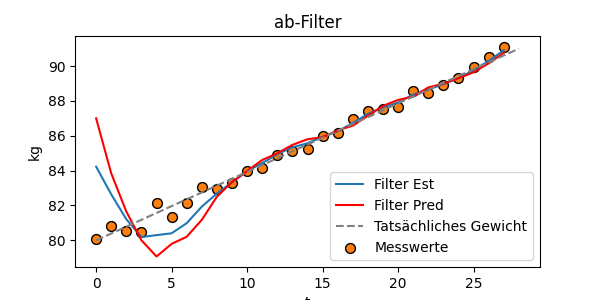

In [3]:
# Daten: Körpergewichte über n Tage verteilt gemessen
count = 28
def data_generator(x_0, dx, count, noise_factor):
    return [x_0 + dx * i + np.random.randn() * noise_factor for i in range(count)]

gewichte = data_generator(79.9, 0.4, count, 0.3) # kg
#print(gewichte)
zeitabstaende = [i for i in range(28)] # n Tage
print()
# Initialisierung und Ausführung des ab-Filters
gewicht_filter = abFilter(x_0=86, dx=1, a=0.4, b=0.2, dt=1.)
pr = gewicht_filter.step(values=gewichte)

# Ploten der Filter Ergebnisse im Vergleich zu den den echten Werten
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(pr[0], label='Filter Est')
ax.plot(pr[1], label='Filter Pred', color='r')
ax.scatter(zeitabstaende, gewichte, s=50, facecolor='C1', edgecolor='k', label='Messwerte')
ax.plot([0,count], [80., 91.], label='Tatsächliches Gewicht', linestyle='--', color='grey')
ax.set_xlabel('t')
ax.set_ylabel('kg')
ax.set_title("ab-Filter")
ax.legend()

Die von uns gewählte initiale Schätzung von 86 kg war mit Absicht sehr hoch gewählt. Wir sehen daher einen großen Ausschlag zu Beginn, schließlich benötigt der Filter einige Iterationen, um sein Werte anzupassen, so dass der Filter zum Ende hin eine deutlich bessere Schätzung ausgiebt.

## Kalman Filter

Das Kalman Filter ist ein Algorithmus, der anhand einer Reihe von Messungen über eine gewisse Zeit unbekannte Variablenwerte eines Systems schätzt. Dabei versucht das Filter Unsicherheiten durch statistisches Rauschen und den Einbezug eines zu Grunde liegenden physiklasichen Modells zu reduzieren.

In unserem Fall versuchen wir mit das Kalman Filter die Position eines Objekts erst im eindimensionalen Raum, dann in einem dreidimensionalen Raum vorherzusagen,. Die Messwerte liefert uns dabei eine Radarsensor Simulation.

Die Klasse KalmanFilter implementiert das Kalman Filter und besteht aus zwei Methoden. Über die __init__(self, s_hat, transition_model, H, Q, R) Methode kann das Kalman Filter mit folgenden Parametern initialisiert werden:

    s_hat ist die Position des Objekts im Raum (x, y, z Koordianten)
    P_hat ist die Kovarianz des Zustands
    model/transition_model ist das zu Grunde liegene physikalische Modell
    H ist die Messfunktion
    Q beschreibt das Prozessrauschen
    R beschreibt das Messrauschen

Nach der Initialisierung kann die step(self,z) Funktion mit den Messwerten z aufgerufen werden, um den Kalman Algorithmus auszuführen.

In [4]:
class KalmanFilter:
    # Initialisierung von Kalman Filter
    def __init__(self, s_hat, transition_model, H, Q, R):
        self.s_hat = s_hat
        self.P_hat = np.eye(len(s_hat)) * 100
        self.model = transition_model
        self.H = H # Measurement Function
        self.Q = Q # Process Noise
        self.R = R # Measurement Noise.
    
    def step(self, z):
        # Prediction
        s_hat_p = self.model @ self.s_hat
        P_hat_p = self.model @ self.P_hat @ self.model.T + self.Q
        # Calculate Kalman Gain
        K = P_hat_p @ self.H.T @ np.linalg.inv(self.H @ P_hat_p @ self.H.T + self.R)
        # Update covariance of estimation error
        self.P_hat = self.P_hat - K @ self.H @ self.P_hat
        # Improve estimate
        e_m_p = z - self.H @ s_hat_p
        self.s_hat = s_hat_p + K @ e_m_p
        return self.s_hat

Im Detail führt die step(self,z) Methode dann folgende Schritte nacheinander aus:

    Vorhersage der neuen Position durch s_hat_p = self.model @ self.s_hat
    Berechnung der Kovarianz des Zustands durch P_hat_p = self.model @ self.P_hat @ self.model.T + self.Q
    Berechung des Kalman Gain durch K = P_hat_p @ self.H.T @ np.linalg.inv(self.H @ P_hat_p @ self.H.T + self.R)
    Aktualisierung der Kovarianz des Zustands durch self.P_hat = self.P_hat - K @ self.H @ self.P_hat
    Verbesserung der Schätzung durch e_m_p = z - self.H @ s_hat_p und self.s_hat = s_hat_p + K @ e_m_p

Zum Schluss wird die neu geschätzte Position zurückgegeben.

Um den Filter zu testen, initialisieren wir ihn mit folgenden Werten für transition_model, Q, H, R:


## 1D Radarsensor

In diesem Abschnitt befinden sich Simulation, Kalman Filter und Experiment für den 1D Radarsensor.

### 1D-Radar-Sensor Simulation

Die Simulation für den 1D Radarsensor gibt uns die Wahl zwischen fünf verschiedenen Bewegungsarten: Static, Constant Velocity, Constant Acceleration, Sinus und Triangle, sowie die Möglichkeit einen Sporadic Error zu den Sensordaten hinzuzufügen.  
Zudem lassen sich an dieser Stelle die Sensor Eigenschaften anspassen.

### Experiment für den 1D Radarsensor

In unserem Experiment für die Daten aus dem eindimensionalen Radarsensor haben wir nachfolgend alle Bewegungsarten simuliert und an das Kalman Filter übergeben.

#### Verhalten und Beschreibung für Static

![1DExpStatic](RadarSensor1D/1DExpStatic.png)

#### Verhalten und Beschreibung für Static mit Sporadic Error

![1DExpStaticEr](RadarSensor1D/1DExpStaticEr.png)

#### Verhalten und Beschreibung für ..



#### Verhalten und Beschreibung für .. mit Sporadic Error




Wenn das Jupyter Notebook ausgeführt wird, können die nachfolgenden Parameter beliebig angepasst werden, um eine Simulation mit dem Kalman Filter auszuprobieren.

In [5]:
# Optionen für die Simulation
opt = {
    "initialDistance": 8,
    "stopTime": 1,
    # "velocity": 3,
    # "SporadicError": 2
     "initialVelocity": 3,
     "acceleration": 1,
    # "movementRange": 1,
    # "frequency": 2,
    # "SporadicError": 2
    }

# timeAxis, distValues, velValues = GenerateData(type="ConstantVelocity", options=opt)
timeAxis, distValues, velValues, truthDistValues, truthVelValues = GenerateData(type="ConstantAcceleration", options=opt)

NameError: name 'GenerateData' is not defined

In [ ]:
R = np.diag([rangeAccuracy**2, velocityAccuracy**2])/3
Q = Q_discrete_white_noise(dim=3, dt=1., var=0.01)
s0 = np.array([distValues[0], velValues[0], 0])
transition_model = np.array([[1, 0.01, 0.01/2],
                             [0, 1, 0.01],
                             [0, 0, 0.01]])
H =  np.array([[1., 0., 0.],
               [0., 1., 0.]])

KalmanFilter = KalmanFilter(s0, transition_model, H, Q, R)

Predictions = [s0]
for i in range(1,np.size(timeAxis)):
    s = np.array([distValues[i], velValues[i]])
    pred = KalmanFilter.step(s)
    Predictions.append(pred)

plt.figure()
plt.plot(timeAxis, distValues)
plt.plot(timeAxis, velValues)
plt.plot(timeAxis, truthDistValues)
plt.plot(timeAxis, truthVelValues)
plt.plot(timeAxis, Predictions)
plt.xlabel("time in s")
plt.legend(["Distance", "Velocity", "Truth distance", "Truth velocity", "Predictions"])
plt.title("Measurement Data of a 1D Radar Sensor")
plt.grid(True)
plt.show()

# Um wie viel hat sich die Messgenauigkeit verbessert?
# Wie beeinflussen die Schätzung der Kovarianzmatrix Q und R die Genauigkeit
# Fügen Sie zufällige Messfehler mit der Parameter "SporadicError" hinzu, wie verhält sich das Kalman Filter?


## 3D Radarsensor

### 3D-Radar-Sensor Simulation

In [ ]:
minRange = 0.3  # m
maxRange = 25.0  # m
maxVelocity = 25  # m/s --> 90 km/h
rangeAccuracy = 0.05  # m
velocityAccuracy = 0.005  # m/s
measurementRate = 30  # Hz
sensorPosition = np.array([0,0,0.8]) # x,y,z-coordinate of the sensor

In [ ]:
class Target:
    def __init__(self, opt):
        self.ValidateOption(opt)
        self.currentPosition = self.opt['InitialPosition']
        self.Trajectory = [self.opt['InitialPosition']]
        self.velocityVector = np.zeros((3,))
        self.pathCounter = 0  
        self.reachedEnd = False      

    def ValidateOption(self, opt):
        if(('InitialPosition' in opt) == False):
            raise Exception("Missing value for 'InitialPosition'")
        else:
            if(type(opt['InitialPosition']) is not np.ndarray):
                raise Exception("InitialPosition should be a np.ndarray with the shape (3,).")
            else:
                if(np.shape(opt['InitialPosition']) != (3,)):
                    raise Exception("InitialPosition should be a np.ndarray with the shape (3,).")

        if(('Path' in opt) == False):
            raise Exception("Missing value for 'Path'")
        else:
            if(type(opt['Path']) is not np.ndarray):
                raise Exception("Path should be a np.ndarray with the shape (3,n).")
            else:
                if(np.size(opt['Path'],0) != 3):
                    raise Exception("Path should be a np.ndarray with the shape (3,n).")

        if(('Velocities' in opt) == False):
            raise Exception("Missing value for 'Velocities'")
        else:
            if(type(opt['Velocities']) is not np.ndarray):
                raise Exception("Velocities should be a np.ndarray with the shape (1,n).")
            else:
                if(np.size(opt['Velocities'],0) != 1):
                    raise Exception("Velocities should be a np.ndarray with the shape (1,n).")

                if(np.size(opt['Velocities'],1) != np.size(opt['Path'],1)):
                    raise Exception("Velocities and Path should have the same length.")

        self.opt = opt

    def Step(self, deltaTime):
        # check if we are at the end
        if(self.pathCounter > np.size(self.opt['Path'],1) - 1):
            self.reachedEnd = True
            return self.currentPosition, self.velocityVector
                
        velocityVector = self.__GetVelocityVector(self.currentPosition, self.opt['Path'][:, self.pathCounter], self.opt['Velocities'][0, self.pathCounter])

        # try to step
        nextPosition = self.currentPosition + velocityVector * deltaTime

        # now check if we are within the next path target
        if(np.linalg.norm(nextPosition - self.currentPosition) < np.linalg.norm(self.opt['Path'][:, self.pathCounter] - self.currentPosition)):
            self.currentPosition = nextPosition
            self.Trajectory.append(nextPosition)
            self.velocityVector = velocityVector
            return self.currentPosition, self.velocityVector

        else: # we have to microstep
            # get the time to current path target
            countDown = deltaTime
            stepFurther = True
            while(stepFurther == True):
                microtime = (np.linalg.norm(self.opt['Path'][:, self.pathCounter] - self.currentPosition)/np.linalg.norm(nextPosition - self.currentPosition)) * countDown
                resttime = countDown - microtime

                if(self.pathCounter + 1 == np.size(self.opt['Path'],1)):
                    stepFurther == False
                    self.pathCounter = self.pathCounter + 1
                    self.velocityVector = np.zeros((3,))
                    self.currentPosition = self.opt['Path'][:, self.pathCounter - 1]
                    self.reachedEnd = True
                    return self.currentPosition, self.velocityVector

                velocityVector = self.__GetVelocityVector(self.opt['Path'][:, self.pathCounter], self.opt['Path'][:, self.pathCounter + 1], self.opt['Velocities'][:, self.pathCounter + 1])
                # try to step
                nextPosition = self.opt['Path'][:, self.pathCounter] + velocityVector * resttime

                if(np.linalg.norm(nextPosition - self.opt['Path'][:, self.pathCounter]) < np.linalg.norm(self.opt['Path'][:, self.pathCounter + 1] - self.opt['Path'][:, self.pathCounter])):
                    stepFurther = False 

                # we proceed to next path target
                self.pathCounter = self.pathCounter + 1

            self.velocityVector = velocityVector
            self.currentPosition = nextPosition
            self.Trajectory.append(nextPosition)
            return self.currentPosition, self.velocityVector

    def __GetVelocityVector(self, Position1, Position2, Velocity):
        targetPosition = Position2
        movementDirection = targetPosition - Position1
        movementDirection = movementDirection / np.linalg.norm(movementDirection)

        return Velocity * movementDirection
    
class RadarSensor:
    def __init__(self, opt):
        self.ValidateOption(opt)
        opt['MinRange'] = minRange
        opt['MaxRange'] = maxRange
        opt['MaxVelocity'] = maxVelocity
        opt['RangeAccuracy'] = rangeAccuracy
        opt['VelocityAccuracy'] = velocityAccuracy
        opt['MeasurementRate'] = 30

    def ValidateOption(self, opt):
        if(('Position' in opt) == False):
            raise Exception("Missing value for 'Position'")
        else:
            if(type(opt['Position']) is not np.ndarray):
                raise Exception("Position should be a np.ndarray with the shape (3,).")
            else:
                if(np.shape(opt['Position']) != (3,)):
                    raise Exception("Position should be a np.ndarray with the shape (3,).")

        if(('OpeningAngle' in opt) == False):
            raise Exception("Missing value for 'OpeningAngle'")
        else:
            if(type(opt['OpeningAngle']) is not np.ndarray):
                raise Exception("OpeningAngle should be a np.ndarray with the shape (2,).")
            else:
                if(np.size(opt['OpeningAngle'],0) != 2):
                    raise Exception("OpeningAngle should be a np.ndarray with the shape (2,).")

        self.opt = opt

    def Detect(self, targets):
        if len(targets) == 0:
            return None

        # initiate list
        detections = []

        # looping through targets
        for target in targets:
            visibleHor = False
            visibleVer = False
            
            # check horizontal angle
            horAngle = np.rad2deg(np.arctan((target.currentPosition[0] - self.opt['Position'][0])/(target.currentPosition[1] - self.opt['Position'][1])))
            if(np.abs(horAngle) < self.opt['OpeningAngle'][0]/2.0):
                visibleHor = True

            # check vertical angle
            verAngle = np.rad2deg(np.arctan((target.currentPosition[2] - self.opt['Position'][2])/(target.currentPosition[1] - self.opt['Position'][1])))
            if(np.abs(verAngle) < self.opt['OpeningAngle'][1]/2.0):
                visibleVer = True

            # if target visible
            if(visibleVer == True and visibleHor == True):            
                currPos = target.currentPosition - self.opt['Position']

                if(np.linalg.norm(currPos) > self.opt['MinRange'] and np.linalg.norm(currPos) < self.opt['MaxRange']):
                    bVector = self.opt['Position'] - target.currentPosition
                    radialVelocityToSensor = (np.dot(target.velocityVector, bVector)/np.dot(bVector, bVector)) + np.random.uniform(-1*self.opt['VelocityAccuracy'],self.opt['VelocityAccuracy'],1)
                    currPos = currPos + np.random.uniform(-1*self.opt['RangeAccuracy'],self.opt['RangeAccuracy'],3)
                    currPos = np.append(currPos, radialVelocityToSensor)

                    if(radialVelocityToSensor < self.opt['MaxVelocity']):
                        detections.append(currPos)


        # add noise / false detection ?
        if(('FalseDetection' in self.opt) == True):
            if(self.opt['FalseDetection'] == True):
                for i in range(20):
                    randPos = np.random.uniform(self.opt['MinRange'], 2 * self.opt['MaxRange'], 3)
                    randVel = np.random.uniform(0, 2 * self.opt['MaxVelocity'], 1)
                    visibleHor = False
                    visibleVer = False
                    
                    # check horizontal angle
                    horAngle = np.rad2deg(np.arctan((randPos[0] - self.opt['Position'][0])/(randPos[1] - self.opt['Position'][1])))
                    if(np.abs(horAngle) < self.opt['OpeningAngle'][0]/2.0):
                        visibleHor = True

                    # check vertical angle
                    verAngle = np.rad2deg(np.arctan((randPos[2] - self.opt['Position'][2])/(randPos[1] - self.opt['Position'][1])))
                    if(np.abs(verAngle) < self.opt['OpeningAngle'][1]/2.0):
                        visibleVer = True

                    # if target visible
                    if(visibleVer == True and visibleHor == True):            
                        randPos = randPos - self.opt['Position']

                        if(np.linalg.norm(randPos) > self.opt['MinRange'] and np.linalg.norm(randPos) < self.opt['MaxRange']):
                            bVector = self.opt['Position'] - randPos
                            randPos = randPos + np.random.uniform(-1*self.opt['RangeAccuracy'],self.opt['RangeAccuracy'],3)
                            randPos = np.append(randPos, randVel)
                            if(randVel < self.opt['MaxVelocity']):
                                detections.append(randPos)

        return detections


### Kalman Filter für den 3D Radarsensor

In [ ]:
class KalmanFilter:
    # Initialisierung von Kalman Filter
    def __init__(self, s_hat, transition_model, H, Q, R):
        self.s_hat = s_hat
        self.P_hat = np.eye(len(s_hat)) * 100
        self.model = transition_model
        self.H = H # Measurement Function
        self.Q = Q # Process Noise
        self.R = R # Measurement Noise.
        pass

    def step(self,z):
        # Prediction
        s_hat_p = self.model @ self.s_hat
        P_hat_p = self.model @ self.P_hat @ self.model.T +  self.Q
        # Calculate Kalman Matrix
        K = P_hat_p @ self.H.T @ np.linalg.inv(self.H @ P_hat_p @ self.H.T + self.R)
        # Update covariance of estimation error
        self.P_hat = self.P_hat - K @ self.H @ self.P_hat
        # Improve estimate
        e_m_p = z - self.H @ s_hat_p
        self.s_hat = s_hat_p + K @ e_m_p
        
        return self.s_hat

if __name__ == "__main__":
    
    # Measurement Error
    ## Variance of a uniform distribution is given by (b-a)**2/12.
    R = np.diag([1**2, 1**2])/3
    # todo: Add variance.
    Q = np.diag([0.05,0.05,0.05])
    # todo: add column for acceleration
    s0 = np.array([[1,1],
                   [2,2],
                   [3,3]])
    #todo: Add acceleration.
    transition_model = np.array([[1, 0.01, 0.01/2],
                                 [0, 1, 0.01],
                                 [0, 0, 0.01]])
    # todo: adjust H for accomodating acceleration.
    H =  np.array([[1., 0., 0.],
                   [0., 1., 0.]])
    kf = KalmanFilter(s0, transition_model, H, Q, R)

### DBScan

Der DBSCAN Algorithmus findet vorhande Cluster in einer Menge an Datenpunkten. Um diese Aufgabe zu erfüllen hat der Algorithmus zwei verstellbare Parameter. Zum einen den Paramater `eps`, der bestimmt in welchem Radius um den Datenpunkt nach Nachbarn gesucht wird, und zum anderen den Parameter `minpts`, der festlegt wie viele Punkte es minimal braucht damit es sich um einen Kernobjekt handelt.\
Da sich die gefunden Cluster mit dem verstellen der Parameter ändern können müssen diese auf das jeweilige Problem angepasst werden.

Für den DBSCAN wurde eine Klasse erstellt, durch die der Algorithmus mit den beiden zuvor geannten Parametern initialisiert wird. Einmal initialisiert kann man den Algorithmus mit den gesetzten Parametern auf verschiedene Datensätze anwenden.

In [ ]:
class DBSCAN():
    def __init__(self, eps=0.5, minpts=5):
        self.eps = eps
        self.minpts = minpts

Um die Cluster in einem bestimmten Datensatz zu finden besitzt die DBSCAN Klasse die Funktion `fit(self, X)`. Dabei entspricht `X` dem Datensatz der analysiert werden soll. Innerhalb dieser Funktion wird der DBSCAN Algorithmus auf die Daten aus `X` angewendet und die einzelnen Datenpunkte werden als Kernobjekte, Dichte-erreichbare Objekte und Rauschpunkte kategorisiert.\
Für die Bestimmung der Punkte Art wird der Abstand zwischen zwei Punkten benötigt. Um diesen Abstand zu bestimmen wird die Hilfsfunktion `pairwise_sq_distance` erstellt.

In [ ]:
def pairwise_sq_distance(X1, X2):
    # Calculate the pairwise distance between all pairs of points from X1 and X2.
    return np.sum(X1**2, axis=1, keepdims=True) - 2*np.matmul(X1, X2.T) + np.sum(X2**2, axis=1, keepdims=True).T

In [ ]:
def fit(self, X):
    dist = pairwise_sq_distance(X, X)
    neighbours = list(map(lambda d: np.arange(d.shape[0])[d < self.eps**2], dist))
    
    # Label all points as outliers initially.
    self.assignment = np.full((X.shape[0],), -1, dtype=int)
    # Find core points.
    # Determine the number of neighbors of each point.
    N_neighbors = np.sum(dist < self.eps**2, axis=1)
    self.assignment[N_neighbors >= self.minpts] = -2
    
    # Create clusters.
    cluster = 0
    stack = deque()
    for p in range(X.shape[0]):
        if self.assignment[p] != -2:
            continue
            
        self.assignment[p] = cluster
        
        stack.extend(neighbours[p])
        # Expand cluster outwards. 
        while len(stack) > 0:
            n = stack.pop()
            label = self.assignment[n]
            # If core point include all points in ε-neighborhood.
            if label == -2:
                stack.extend(neighbours[n])
            # If not core point (edge of cluster).
            if label < 0:
                self.assignment[n] = cluster
        
        cluster += 1

DBSCAN.fit = fit

Die Funktion `fit` findet die verschiedenen Cluster und speichert diese in der Variable `assignments` ab. Das heißt wenn ich die Methode `fit` aufrufe werden nicht die gefundenen Cluster zurückgegeben. Für diese Aktion existiert die `predict` Methode.\
Zusätzlich zu der basis `predict` Funktion gibt es auch die Methode `fit_predict`. Diese ruft zuerst `fit` auf, also findet die Cluster, und danach `predict`, also um die Werte zurückzugeben. Das heißt wenn man den Algorithmus zum ersten mal auf einen Datensatz anwendet und direkt das Ergebnis haben will sollte die Funktion `fit_predict` verwendet werden. Wenn man das Ergebnis des Algorithmus zu einem spätern Zeitpunkt nochmal benötigt muss nur noch `predict` ausgeführt werden. Kurz gesagt kann durch die Aufsplittung von `fit` und `predict` Rechenaufwand reduziert werden.

In [ ]:
def predict(self,X):
    return self.assignment

def fit_predict(self, X):
    self.fit(X)
    return self.assignment

DBSCAN.predict = predict
DBSCAN.fit_predict = fit_predict

Um den DBSCAN zu testen haben wir den `make_moons` Datensatz von scikitlearn genutzt. Das Ergebnis kann man hier sehen:

In [ ]:
from sklearn.datasets import make_moons

if __name__ == '__main__':
    X,y = make_moons(100)
    model = DBSCAN()
    preds = model.fit_predict(X)
    # Either low or high values are good since DBSCAN might switch class labels.
    print(f"Accuracy: {round((sum(preds == y)/len(preds))*100,2)}%")
    
    fig= plt.figure(facecolor='w')
    ax = plt.axes()
    plt.plot(X[:, 0][preds==1], X[:, 1][preds==1], "co")
    plt.plot(X[:, 0][preds==0], X[:, 1][preds==0], "ro")

    # X contains two features, x1 and x2
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20)

    # Simplifying the plot by removing the axis scales.
    plt.xticks([])
    plt.yticks([])

    # Displaying the plot.
    plt.show()
    

### Experiment für den 3D Radarsensor

In diesem Experiment sollen ein oder mehrere Ziele in einem drei dimensionalen Raum getrackt werden. Dafür werden der DBSCAN, zur Zielerkennung und der Kalman-Filter zur Laufbahnvorhersage genutzt.

In dem folgenden Code werden diese Ziele und ihre Laufbahnen angelegt:

In [ ]:
# Parameters first target.
path1 = [[0,5,0],
         [0,5,0.5],
         [1,4,1],
         [2,3,2],
         [1,5,3],
         [1,5,0.5],
         [0.5, 2, 0.1]]

vel1 = 3 * np.ones((1,len(path1)))
vel1[0,2] = 1

InitialPosition1 = np.array([-1,5,0])

opt1 = {
    'InitialPosition' : InitialPosition1,
    'Path' : np.array(path1).transpose(),
    'Velocities' : vel1
}

# Parameters second target.
path2 = [[1. , 4. , 1. ],
         [1. , 5. , 1.7],
         [2. , 5. , 1. ],
         [3. , 4. , 2. ],
         [3. , 4. , 1.5],
         [2. , 4. , 2. ]]

vel2 = 2 * np.ones((1,len(path2)))
vel2[0,4] = 0.5

InitialPosition2 = np.array([2,4,1])

opt2 = {
    'InitialPosition' : InitialPosition2,
    'Path' : np.array(path2).transpose(),
    'Velocities' : vel2
}

Zusätzlich wird der Radar Sensor initialisiert:

In [ ]:
'''
Setup the radar sensor
The radar sensor points always to the direction along the y axis
(see diagram in the note)
'''

optRadar = {
    'Position' : np.array([0,0,0.5]),
    'OpeningAngle' : np.array([120,90]), # [Horizontal, Vertical]
    'FalseDetection': True
}
sensor = RadarSensor(optRadar)

Die Bewegung der Ziele findet in einer while-Schleife statt. Dabei wird in jeder Iteration jedes Ziel einen Schritt weiter bewegt. Nachdem ein Schritt durchgeführt wurde versucht der Sensor die Ziele wahrzunehmen und mithilfe des DBSCAN die Ziele zu finden. Die Analyse durch den DBSCAN gibt allerdings erst ab einer in `pt_history` festegelegt Anzahl an Datenpunkten einen Sinn.\
Sobald das erste mal diese Anzahl erreicht wurde wird der DBSCAN in jeder Iteration auf die letzten `pt_history` Datenpunkte angewendet. Die dabei gefundenen Cluster werden den verschiedenen Zielen aus `labeled` zugeordnet. Exisitiert das Ziel noch nicht in diesem Dictionary wird es erstellt.

In [ ]:
def scan(model, pt_history, targets):
    getNext = True
    detections = np.array([0,0,0,0])
    # Count number of iterations
    i = 0
    labeled = {}

    while(getNext == True):
        i += 1
        for target in targets:
            target.Step(1/sensor.opt['MeasurementRate'])
            getNext = getNext & ~target.reachedEnd  

        dets = sensor.Detect(targets)
        for det in dets:
            detections = np.vstack((det, detections))

        if i >= pt_history:
            # First application of DBSCAN.
            clusters = model.fit_predict(detections[:pt_history])
            # Determine number of targets (objects tracked).
            num_objs = set(clusters)

            for j in num_objs:
                # Find index of first occurence of target j in clusters. This line is needed to filter out false detections
                obj_idx = np.where(clusters == j)[0][0]

                if j not in labeled.keys():
                    labeled[j] = detections[obj_idx,:-1]

                s = detections[obj_idx,:-1].reshape(1,3)
                labeled[j] = np.vstack((s, labeled[j]))
                
    return labeled

Werden diese dann visualisiert kann man erkennen, dass einige Datenpunkte Ausreißer sind und der Rest Pfade verschiedener Objekte darstellen. Über das folgende Dictionary wird festgelegt welches Objekt welche Farbe bekommen soll (Es sind so viele, denn je nach Einstellung der Parameter werden mehr als die zwei Realen Objekte gefunden).

In [ ]:
colors = { -1: 'red', 0: 'green', 1: 'yellow', 2: 'blue', 3: 'purple', 4: 'orange', 5: 'pink', 6: 'black', 7: 'brown' }

Um eine gute Einstellung für den DBSCAN zu finden werden zuerst zwei Extreme Einstellungen getestet. Bei der ersten (links) Einstellungen werden die Parameter niedrig und bei der zweiten Einstellung (rechts) hoch initialisiert. Dabei wird die Variable `pt_history` bei einem Wert von konstant 20 belassen (ein Erhöhen dieser Variable entspricht einem Verringern von `minpts` und ein Verringern der Variable entspricht einer Erhöhung von `minpts` (das kann im interaktiven Beispiel am Ende der Sektion überprüft werden)).

In [ ]:
model1 = DBSCAN(eps=0.1, minpts=2)
model2 = DBSCAN(eps=1, minpts=10)
# Number of previous measurements to consider for DBSCAN().
pt_history = 20

# Instantiate targets
x = Target(opt1)
y = Target(opt2)

targets = [x, y]

# Plot Trajectories
fig= plt.figure(figsize=(8,6), dpi= 100, facecolor='w')
labeled1 = scan(model1, pt_history, targets)
print(f'Found {len(labeled1.keys())-1} clusters and {len(labeled1[-1])} outlier!')

ax = fig.add_subplot(1, 2, 1, projection='3d')
for label in labeled1.keys():
    T = labeled1[label];
    ax.scatter(T[:,0], T[:,1], T[:,2], c=f'{colors[label]}')   
    
    
# Instantiate targets
x = Target(opt1)
y = Target(opt2)

targets = [x, y]

labeled2 = scan(model2, pt_history, targets)
print(f'Found {len(labeled2.keys())-1} clusters and {len(labeled2[-1])} outlier!')

# Plot Trajectories
ax = fig.add_subplot(1, 2, 2, projection='3d')
for label in labeled2.keys():
    T = labeled2[label];
    ax.scatter(T[:,0], T[:,1], T[:,2], c=f'{colors[label]}')   

# show plot
plt.style.use('classic')
plt.show()

Das Ergebnis dieses Tests ist, das bei beiden Einstellungen etwas nicht stimmt. Bei der ersten zu niedrigen Einstellung werden zu viele Cluster gefunden. Das liegt vermutlich an einem zu niedrigen Wert für `eps`, denn dadurch werden nur die Punkte mit einer so geringen Entfernung einem Cluster zu geordnet => `eps` erhöhen. Ähnliches passiert bei der zweiten Einstellung. Bei dieser kann zwar Objekte in einem größeren Umkreis finden (was auch passiert), aber er braucht deutlich mehr `minPts` bevor diese zu einem Cluster zählen => `minPts` verringern. 

Ergebend aus unseren ersten beiden Tests ergibt sich das ein für uns gutes Ergebnis zwischen den beiden Extrema liegen muss. Also `eps` hoch und `minPts` runter (bei der Einstellung von `pt_history` = 20). Durch mehrere Tests der selben Art hat sich die folgende Einstellung für uns als gut ergeben.

In [ ]:
model = DBSCAN(eps=0.7, minpts=2)
# Number of previous measurements to consider for DBSCAN().
pt_history = 20

# Instantiate targets
x = Target(opt1)
y = Target(opt2)

targets = [x, y]

labeled = scan(model, pt_history, targets)
print(f'Found {len(labeled.keys())-1} clusters and {len(labeled[-1])} outlier!')

# Plot Trajectories
fig= plt.figure(figsize=(8,6), dpi= 100, facecolor='w')
ax = plt.axes(projection='3d')   
for label in labeled.keys():
    T = labeled[label];
    ax.scatter(T[:,0], T[:,1], T[:,2], c=f'{colors[label]}')   

# show plot
plt.show()

Wie zu sehen werden die beiden Objekte gut durch den DBSCAN erkannt und die Ausreißer erfolgreich rausgefiltert.

In dem folgenden Beispiel können die Parameter `eps`,`minPts` und `ante` verstellt werden um die zu sehen wie die verschiedenen Einstellungen das Ergebnis des DBSCAN beinflussen.

In [ ]:
def update(eps, minpts, pt_history, target_select):
    ax.clear()
    x = Target(opt1)
    y = Target(opt2)
    target_dict = {'Target 1': x, 'Target 2': y}
    
    targets = list()
    for target in target_select:
        if target in target_dict:
            targets.append(target_dict[target])
            
    
    labeled = scan(DBSCAN(minpts=minpts, eps=eps), pt_history, targets)
    print(f'Found {len(labeled.keys())-1} clusters and {len(labeled[-1])} outlier!')

    # Plot Trajectories   
    for label in labeled.keys():
        T = labeled[label];
        ax.scatter(T[:,0], T[:,1], T[:,2], c=f'{colors[label]}')   

    # show plot
    fig.canvas.draw_idle()

In [ ]:
from __future__ import print_function
from ipywidgets import interact, interactive, interactive_output, fixed, interact_manual
import ipywidgets as widgets

fig= plt.figure(figsize=(8,6), dpi= 100, facecolor='w')
ax = plt.axes(projection='3d')

eps_ia = widgets.FloatSlider(
    value=.7,
    min=.1,
    max=1.,
    step=.1,
    description='$\epsilon$',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)

minpts_ia = widgets.IntSlider(
    value=2,
    min=1,
    max=10,
    step=1,
    description='Min. Points',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

pt_history_ia = widgets.IntSlider(
    value=20,
    min=10,
    max=50,
    step=1,
    description='Ante',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

targets_ia = widgets.SelectMultiple(
    options=['Target 1', 'Target 2'],
    value=['Target 1', 'Target 2'],
    #rows=10,
    description='Targets',
    disabled=False
)

#print(type(plt_fdets_ia.value))

ui = widgets.VBox([eps_ia, 
                   minpts_ia,
                   pt_history_ia,
                   targets_ia,
                   ])

out = interactive_output(update, {'eps': eps_ia, 'minpts': minpts_ia, 'target_select': targets_ia, 'pt_history': pt_history_ia})

display(ui, out)

Max Ende

In [ ]:
# imports for interactive plotting
#from ipywidgets import interact, interactive, fixed, interact_manual
#import ipywidgets as widgets
from ipywidgets import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# ipynb plotting
#%matplotlib inline
#%matplotlib widget

'''
Example for creating a target and design its path
'''

# Parameters first target.
path1 = [[0,5,0],
         [0,5,0.5],
         [1,4,1],
         [2,3,2],
         [1,5,3],
         [1,5,0.5],
         [0.5, 2, 0.1]]

vel1 = 3 * np.ones((1,len(path1)))
vel1[0,2] = 1

InitialPosition1 = np.array([-1,5,0])

opt1 = {
    'InitialPosition' : InitialPosition1,
    'Path' : np.array(path1).transpose(),
    'Velocities' : vel1
}


# Parameters second target.
path2 = [[1. , 4. , 1. ],
         [1. , 5. , 1.7],
         [2. , 5. , 1. ],
         [3. , 4. , 2. ],
         [3. , 4. , 1.5],
         [2. , 4. , 2. ]]

vel2 = 2 * np.ones((1,len(path2)))
vel2[0,4] = 0.5

InitialPosition2 = np.array([2,4,1])

opt2 = {
    'InitialPosition' : InitialPosition2,
    'Path' : np.array(path2).transpose(),
    'Velocities' : vel2
}


# Instantiate targets
x = Target(opt1)
y = Target(opt2)


targets = [x, y]

'''
Setup the radar sensor
The radar sensor points always to the direction along the y axis
(see diagram in the note)
'''

optRadar = {
    'Position' : np.array([0,0,0.5]),
    'OpeningAngle' : np.array([120,90]), # [Horizontal, Vertical]
    'FalseDetection': True
}
sensor = RadarSensor(optRadar)

# Measurement error.
## Variance of a uniform distribution is given by (b-a)**2/12.
R = np.diag([rangeAccuracy**2])/3
# Process error.
Q = np.diag([0.05,0.05,0.05])
# Process/transition model.
transition_model = np.array([[1, 0.01, 0.01/2],
                             [0, 1, 0.01],
                             [0, 0, 0.01]])
# Transformation matrix
## Transforms predicted quantities into outputs that can be compared to the measurements
H =  np.array([[1., 0., 0.]])

def update():
    getNext = True
    Detections = np.array([0,0,0])
    model = DBSCAN(eps=0.2, minpts=2)
    # Number of previous measurements to consider for DBSCAN().
    ante = 20
    # Count number of iterations
    i = 0

    while(getNext == True):
        i += 1
        for target in targets:
            target.Step(1/sensor.opt['MeasurementRate'])
            getNext = getNext & ~target.reachedEnd  

        dets = sensor.Detect(targets)
        # Exclude radialVelocity for the moment. (todo: include it.)
        for det in dets:
            det = det[:-1]
            Detections = np.vstack((det, Detections))

        # Execute once to initialize filters etc. todo: Is there a smarter way to do all below ?
        if i == ante:
            # First application of DBSCAN.
            clusters = model.fit_predict(Detections[:ante])
            # Determine number of targets (objects tracked).
            num_objs = len(set(clusters[clusters > -1]))

            # "Filters" contains a kalman filter for each target.
            Filters = []
            # "Preds" contains the predictions of the path of each target.
            Preds = []
            # Iterate over the targets.
            for j in range(num_objs):
                # Find index of first occurence of target j in clusters. This line is needed to filter out false detections
                obj_idx = np.where(clusters == j)[0][0]
                # Add placeholder values for speed and acceleration in each component to the detection.
                s0 = np.vstack((Detections[obj_idx], np.zeros((2,3))))
                Filters.append(KalmanFilter(s0, transition_model, H, Q, R))
                # For the moment only the predicted position is relevant. todo: incorporate velocity.
                Preds.append(s0[0,:])

        # Cluster and predict position via Kalman filter.
        elif i > ante:
            clusters = model.fit_predict(Detections[:ante])
            for j in range(num_objs):
                # try/ except prevents non-detection of existing object from breaking the program.
                try:
                    obj_idx = np.where(clusters == j)[0][0]
                    # Reshape is needed to make matrix multiplication inside the kalman filter work.
                    s = Detections[obj_idx].reshape(1,3)
                    s_hat = Filters[j].step(s)
                    Preds[j] = np.vstack((s_hat[0,:], Preds[j]))
                except IndexError:
                    print(f"Object {j} not found!")
                    continue



    if __name__ == "__main__":
        # Visualize trajectory.
        T1 = Preds[0][:-1]
        T2 = Preds[1][:-1]

        # Plot Trajectory
        fig=plt.figure(figsize=(8,6), dpi= 100, facecolor='w', edgecolor='k')
        #fig = plt.figure()
        ax = plt.axes(projection='3d')   
        #ax.view_init(20, 35) 
        ax.plot3D(T1[:,0], T1[:,1], T1[:,2], 'blue')   
        ax.plot3D(T2[:,0], T2[:,1], T2[:,2], 'red')    

        # show plot
        plt.style.use('classic')
        plt.show()
        

interact(update);

## Verwendete Literatur

1. Kalman and Bayesian Filters in Python, 2015, Roger R. Labbe

[[0.00083333]]


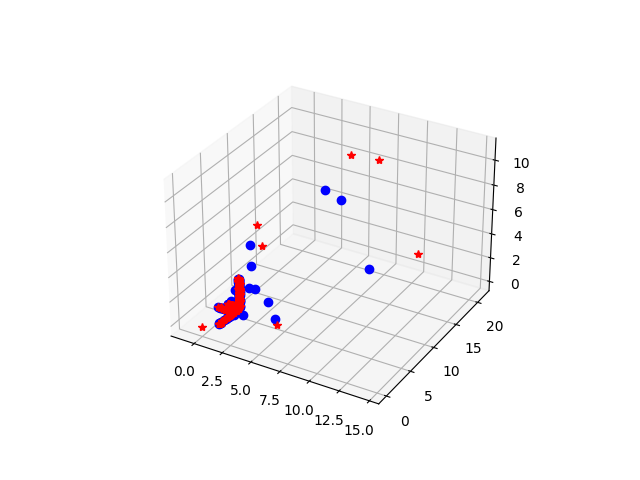

In [47]:
transition_model = np.array([[1, 0.01, 0.01/2],
                             [0, 1,    0.01  ],
                             [0, 0,    0.01 ]])
Q = np.diag([0, 0, 0])
H =  np.array([[1., 0., 0.]])
R = np.diag([rangeAccuracy**2])/3 # Soll gut sein
print(R)

path1 = [[0,   5, 0  ],
         [0,   5, 0.5],
         [1,   4, 1  ],
         [2,   3, 2  ],
         [1,   5, 3  ],
         [1,   5, 0.5],
         [0.5, 2, 0.1]]

vel1 = 3 * np.ones((1,len(path1)))
vel1[0,2] = 1

InitialPosition1 = np.array([-1,5,0])

opt1 = {
    'InitialPosition' : InitialPosition1,
    'Path' : np.array(path1).transpose(),
    'Velocities' : vel1
}

x = Target(opt1)

targets = [x]



optRadar = {
    'Position' : np.array([0, 0, 0.5]),
    'OpeningAngle' : np.array([120,90]), # [Horizontal, Vertical]
    'FalseDetection': True
}
sensor = RadarSensor(optRadar)



Detections = np.array([0,0,0,0])
model = DBSCAN(eps=0.2, minpts=2)
# Number of previous measurements to consider for DBSCAN().
ante = 20
# Count number of iterations
i = 0
pred = []
getNext = True
while(getNext == True):
    
    for target in targets:
        target.Step(1/sensor.opt['MeasurementRate'])
        getNext = getNext & ~target.reachedEnd  

    dets = sensor.Detect(targets)
    # Exclude radialVelocity for the moment. (todo: include it.)
    for det in dets:
        #det = det[:-1]
        Detections = np.vstack((det, Detections))
    
    #print(Detections)
    #print(Detections[0,:])
    s0 = np.vstack((Detections[0,:-1], np.zeros((2,3))))
    
    if i == 0:
        f = KalmanFilter(s0, transition_model, H, Q, R)
        pred.append(s0[0,:])
    
    s = Detections[0,:-1].reshape(1,3)
    s_hat = f.step(s)
    pred = np.vstack((s_hat[0,:], pred))
    i += 1
    

# Visualize trajectory.
T1 = pred[:-1]

# Plot Trajectory
fig = plt.figure()
ax = plt.axes(projection='3d')   
#ax.view_init(20, 35) 
ax.plot3D(T1[:,0], T1[:,1], T1[:,2], 'bo')
ax.plot3D(Detections[:,0], Detections[:,1], Detections[:,2], 'r*')

In [23]:
# Execute once to initialize filters etc. todo: Is there a smarter way to do all below ?
    if i == ante:
        # First application of DBSCAN.
        clusters = model.fit_predict(Detections[:ante])
        # Determine number of targets (objects tracked).
        num_objs = len(set(clusters[clusters > -1]))
        
        # "Filters" contains a kalman filter for each target.
        Filters = []
        # "Preds" contains the predictions of the path of each target.
        Preds = []
        # Iterate over the targets.
        for j in range(num_objs):
            # Find index of first occurence of target j in clusters.
            # This line is needed to filter out false detections
            # obj_idx = np.where(clusters == j)[0][0]
            # Add placeholder values for speed and acceleration in each component to the detection.
            s0 = np.vstack((Detections[obj_idx], np.zeros((2,3))))
            Filters.append(KalmanFilter(s0, transition_model, H, Q, R))
            # For the moment only the predicted position is relevant. todo: incorporate velocity.
            Preds.append(s0[0,:])

    # Cluster and predict position via Kalman filter.
    elif i > ante:
        clusters = model.fit_predict(Detections[:ante])
        for j in range(num_objs):
            # try/ except prevents non-detection of existing object from breaking the program.
            try:
                obj_idx = np.where(clusters == j)[0][0]
                # Reshape is needed to make matrix multiplication inside the kalman filter work.
                s = Detections[obj_idx].reshape(1,3)
                s_hat = Filters[j].step(s)
                Preds[j] = np.vstack((s_hat[0,:], Preds[j]))
            except IndexError:
                print(f"Object {j} not found!")
                continue


IndentationError: unexpected indent (3934707305.py, line 2)